#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import diffusion_utils

import networkx as nx

from copy import deepcopy

from tqdm import tqdm

import random

## Star Network Belief Systems

#### Create the social network

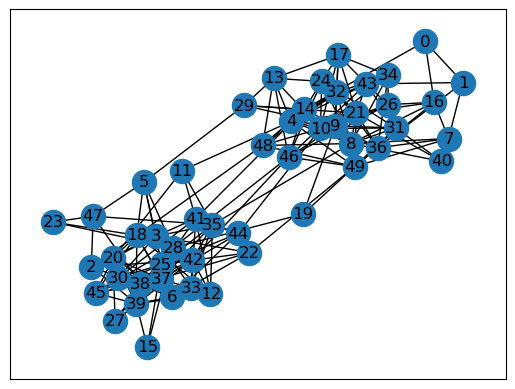

In [2]:
N = 50
M = 400
mu = .05

social_G, communities = diffusion_utils.community_social_network(N = 50, mu = .05, M = 200)

nx.draw_networkx(social_G)

#### Generate and embed the belief networks inside the social network

In [3]:
social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

#### Random walk to close triads

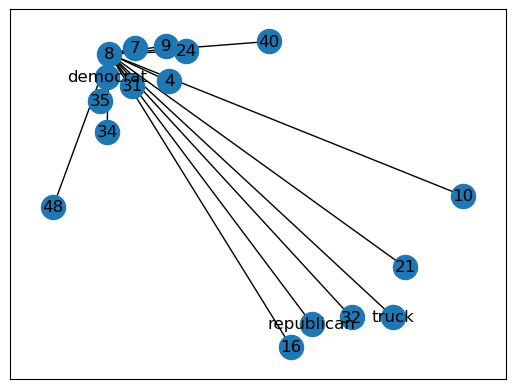

In [4]:
g = social_G.nodes[8]['belief_network']

nx.draw_networkx(g)

In [7]:
del g

In [5]:
def get_avg_measures(social_G):
    
    temp1 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    temp2 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    for e in social_G.edges():
        w1 = social_G.nodes[e[0]]['belief_network'].edges[e]['weight']
        w2 = social_G.nodes[e[1]]['belief_network'].edges[e]['weight']

        diff = abs(w1 - w2)
        comm1 = communities[e[0]] + "s"
        comm2 = communities[e[1]] + "s"
        
        if comm1 != comm2:
            temp1['inter-group'].append(diff)
            temp2['inter-group'].append(w1)
            temp2['inter-group'].append(w2)
        else:
            temp1['intra-group'].append(diff)
            temp2['intra-group'].append(w1)
            temp2['intra-group'].append(w2)
        
        temp1['aggregate'].append(diff)
        temp2['aggregate'].append(w1)
        temp2['aggregate'].append(w2)
    
    return temp1, temp2

In [6]:
def random_walker(g, focal_edge):
    
    node_order = list(g.nodes())
    #print("Node Order:", node_order)

    # Create mappings
    index_to_node = {i: node for i, node in enumerate(node_order)}
    node_to_index = {node: i for i, node in enumerate(node_order)}
    
    # get the adjacency matrix
    adj = nx.adjacency_matrix(g)

    # take the absolute value of all
    abs_adj = abs(adj)

    # sum of columns will be used to normalize the values
    normalizer = abs_adj.sum(axis=0)

    # normalize the values columnwise
    abs_adj_normalized = abs_adj/normalizer

    # probabilities for a two-step random walk
    random_walk_probs = (abs_adj_normalized**2).todense()

    # choose one of the nodes from the edge as the starter node
    i = np.random.choice([0,1])
    starting_node = focal_edge[i]
    middle_node = focal_edge[i-1]

    # determine the column number of the middle node in the adj matrix
    col = node_to_index[middle_node]

    # extract the probabilities that starting from the starter node,
    # what are the probabilities ending up in the other nodes in k jumps?
    probabilities = random_walk_probs[:,col].flatten()

    # choose a node depending on the probabilities
    ending_node = random.choices(node_order, weights=probabilities, k=1)[0]

    return starting_node, middle_node, ending_node

In [8]:
def assign_weight_to_new_edge(g, starting_node, middle_node, ending_node):
    
    # compute the multiplication of starting to middle and middle to ending node edges
    curr_multiplication = g.edges[(starting_node, middle_node)]['weight'] * g.edges[(middle_node, ending_node)]['weight']
    
    # assign a random initial weight drawn from normal distribution that ensures cognitive
    # consonance for the triad

    dissonant = True

    while dissonant:
        initial_weight = np.random.normal(0, .2)
        if curr_multiplication * initial_weight < 0:
            dissonant = False
    
    return initial_weight

In [9]:
N = 50
M = 400
mu = .05

log = {}

for sim in range(50):
    
    # initialize the social network
    social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

    # embed the belief networks into social networks
    social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

    avg_diff = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    avg_w = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    
    T = N * 100
    
    for t in tqdm(range(T+1)):
        
        # Randomly choose a sender, receiver and focal edge
        sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_mutual_belief(social_G)
        
        # republican and democrat beliefs do not change
        if ('republican' not in focal_edge) & ('democrat' not in focal_edge):
            
            # Calculate the updated weight after agents interact
            b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender, receiver, 
                                                                  focal_edge, alpha=1.5, beta=1)
            
            # Update the belief in the network
            diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                               b_i_plus_1)
        
        # Extract the receiver's belief network
        g = social_G.nodes[receiver]['belief_network']
        
        # Agent thinks to themselves after updating their belief (apply random walk)
        starting_node, middle_node, ending_node = random_walker(g, focal_edge)
        
        # If starting node is the same as the ending node, we cannot change anything...
        if starting_node != ending_node:
            # ... if not, we randomly assign a weight to the new edge
            initial_weight = assign_weight_to_new_edge(g, starting_node, middle_node,
                                                       ending_node)
            
            # Connect starting and ending nodes to each other with the initial weight
            g.add_edge(starting_node, ending_node, weight=initial_weight)
            
            # Put the receiver's belief network back (might be done automatically)
            social_G.nodes[receiver]['belief_network'] = g
        
        temp1, temp2 = get_avg_measures(social_G)
        
        for k,v in temp1.items():
            avg_diff[k].append(np.mean(v))
        
        for k,v in temp2.items():
            avg_w[k].append(np.mean(v))
    
    log[sim] = {}
    log[sim]['avg_diff'] = avg_diff
    log[sim]['avg_w'] = avg_w

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:07<00:00, 702.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:07<00:00, 685.07it/s]


In [14]:
[len(v['avg_diff']['intra-group']) for v in log.values()]

[3483,
 3542,
 3595,
 3603,
 3491,
 3583,
 3660,
 3475,
 3592,
 3726,
 3613,
 3729,
 3645,
 3464,
 3497,
 3757,
 3595,
 3542,
 3595,
 3594,
 3837,
 3506,
 3642,
 3570,
 3765,
 3613,
 3570,
 3544,
 3583,
 3654,
 3460,
 3602,
 3620,
 3428,
 3566,
 3616,
 3636,
 3626,
 3567,
 3619,
 3566,
 3456,
 3478,
 3562,
 3497,
 3653,
 3642,
 3637,
 3598,
 3646]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.

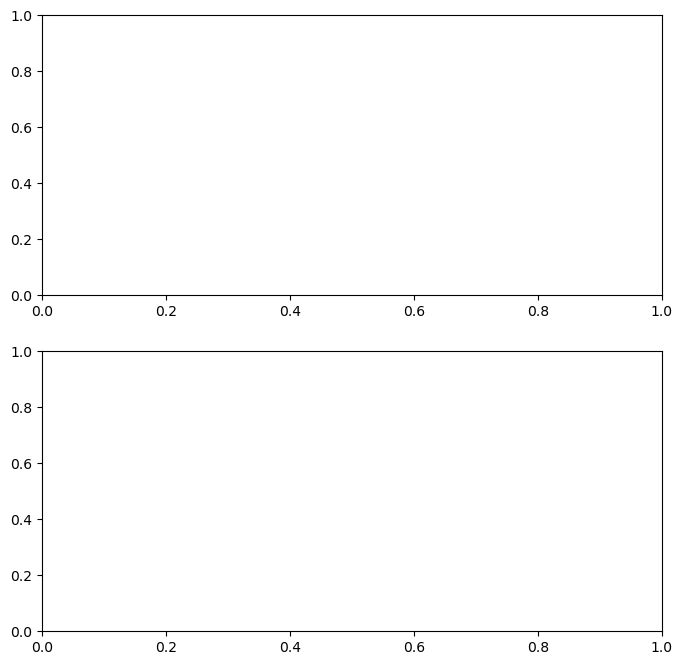

In [10]:
fig, axs = plt.subplots(2,1,figsize=(8,8))

for i, d, ylabel in zip([0,1], ['avg_diff', 'avg_w'], ['Avg. Diff.', 'Avg. Weight']):
    for l in ['inter-group', 'intra-group', 'aggregate']:
        avg = np.mean([v[d][l] for v in log.values()], axis=0)
        std = np.std([v[d][l] for v in log.values()], axis=0)
        axs[i].plot(avg, 
                    label=l.capitalize())
        
        axs[i].fill_between(range(len(avg)),
                            avg+(std/2), avg-(std/2),
                            label=l.capitalize(),
                            alpha=.3)
    
    axs[i].set_ylabel(ylabel)
    axs[i].grid(alpha=.3)
    
axs[0].legend(frameon=False)

fig.show()